In [23]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Add the processing directory to path
sys.path.insert(0, '../proc/apres')

# Import our Python ApRES processing module
import apres_python as apres

# Data directory
DATAHOME = os.environ.get('DATAHOME', '../data')
RAW_DATA = Path(DATAHOME) / 'apres' / 'raw'

print(f"Data directory: {RAW_DATA}")
print(f"Exists: {RAW_DATA.exists()}")

Data directory: ../data/apres/raw
Exists: True


## 1. List Available ApRES Files

In [24]:
# Find all .DAT files
dat_files = sorted(RAW_DATA.glob('*.DAT'))
print(f"Found {len(dat_files)} ApRES data files")

# Show first and last few files
print("\nFirst 5 files:")
for f in dat_files[:5]:
    print(f"  {f.name}")

print("\nLast 5 files:")
for f in dat_files[-5:]:
    print(f"  {f.name}")

Found 1878 ApRES data files

First 5 files:
  DATA2019-01-18-0231.DAT
  DATA2019-01-18-0631.DAT
  DATA2019-01-18-1031.DAT
  DATA2019-01-18-1431.DAT
  DATA2019-01-18-1831.DAT

Last 5 files:
  DATA2019-11-25-0702.DAT
  DATA2019-11-25-1102.DAT
  DATA2019-11-25-1502.DAT
  DATA2019-11-25-1902.DAT
  DATA2019-11-25-2302.DAT


## 2. Load and Examine a Single File

In [25]:
# Load the first file to examine the data structure
test_file = str(dat_files[0])
print(f"Loading: {dat_files[0].name}\n")

# Load the raw data
data = apres.fmcw_load(test_file)

print("=== ApRES Data Summary ===")
print(f"File format: {data.file_format}")
print(f"Time stamp: {data.time_stamp}")
print(f"Number of subbursts: {data.n_subbursts}")
print(f"Samples per subburst: {data.n_adc_samples}")
print(f"Sampling frequency: {data.sampling_freq} Hz")
print(f"\nFrequency parameters:")
print(f"  f0 (start): {data.f0/1e6:.1f} MHz")
print(f"  f1 (end): {data.f1/1e6:.1f} MHz")
print(f"  Bandwidth: {data.bandwidth/1e6:.1f} MHz")
print(f"  Chirp time: {data.chirp_time} s")
print(f"\nMedium parameters:")
print(f"  Permittivity: {data.er}")
print(f"  Wave speed: {data.ci/1e6:.3f} x 10^6 m/s")
print(f"  Center wavelength: {data.lambdac*100:.2f} cm")

Loading: DATA2019-01-18-0231.DAT

=== ApRES Data Summary ===
File format: 5
Time stamp: 2019-01-18 02:31:26
Number of subbursts: 40
Samples per subburst: 40001
Sampling frequency: 40000 Hz

Frequency parameters:
  f0 (start): 200.0 MHz
  f1 (end): 400.0 MHz
  Bandwidth: 200.0 MHz
  Chirp time: 1.0 s

Medium parameters:
  Permittivity: 3.18
  Wave speed: 168.232 x 10^6 m/s
  Center wavelength: 56.08 cm


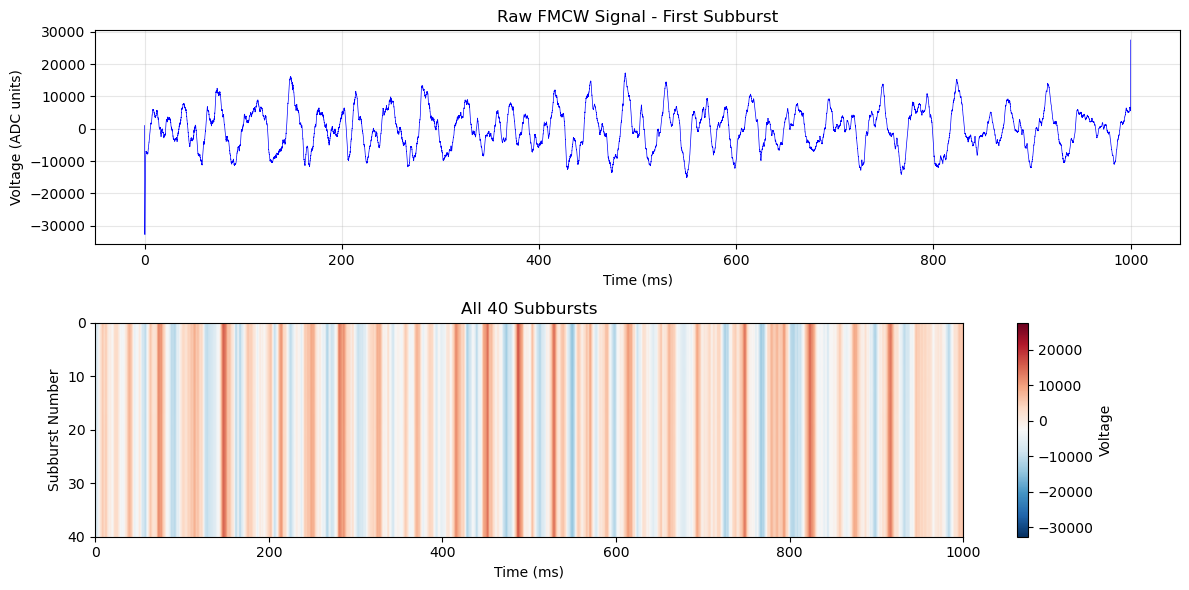

In [26]:
# Visualize the raw voltage data
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Time-domain signal for one subburst
ax1 = axes[0]
t_ms = data.t * 1000  # Convert to milliseconds
ax1.plot(t_ms, data.vdat[0, :], 'b-', linewidth=0.5)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (ADC units)')
ax1.set_title('Raw FMCW Signal - First Subburst')
ax1.grid(True, alpha=0.3)

# Show all subbursts as a waterfall/image
ax2 = axes[1]
im = ax2.imshow(data.vdat, aspect='auto', cmap='RdBu_r',
                extent=[0, t_ms[-1], data.n_subbursts, 0])
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Subburst Number')
ax2.set_title(f'All {data.n_subbursts} Subbursts')
plt.colorbar(im, ax=ax2, label='Voltage')

plt.tight_layout()
plt.show()

## 3. Process to Range Profile

Apply the FMCW processing to convert the time-domain signal to a range profile using FFT and phase correction.

In [27]:
# Process to range
Rcoarse, Rfine, spec_cor, spec = apres.fmcw_range(data, pad_factor=2, max_range=2000)

print(f"Range vector: {len(Rcoarse)} bins")
print(f"Range resolution: {Rcoarse[1] - Rcoarse[0]:.3f} m")
print(f"Max range: {Rcoarse[-1]:.1f} m")

# Average spectrum across all subbursts
spec_avg = np.mean(np.abs(spec_cor), axis=0)
spec_avg_db = 10 * np.log10(spec_avg**2 + 1e-30)  # Power in dB

Range vector: 9512 bins
Range resolution: 0.210 m
Max range: 2000.1 m


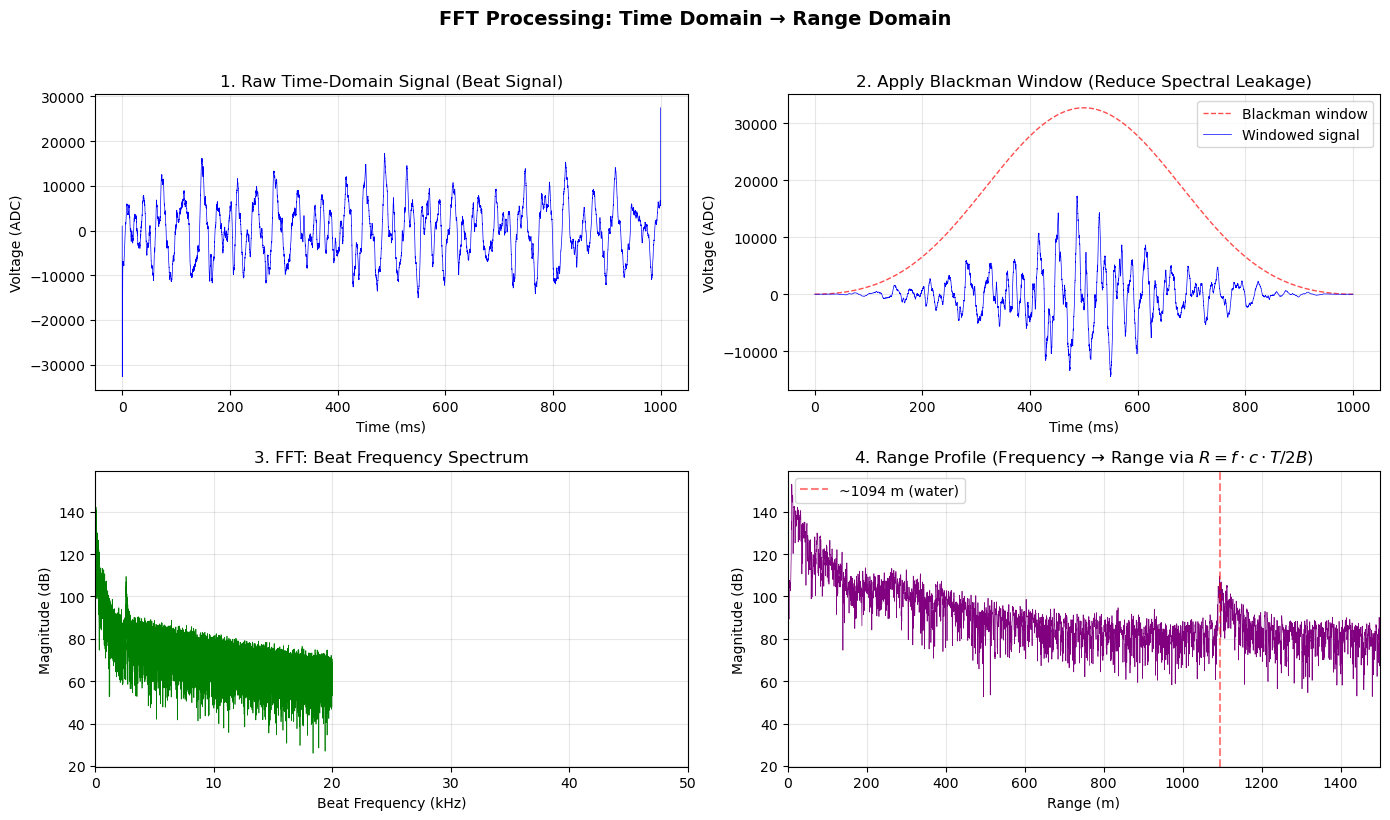

FFT Processing Summary:
  Input: 40001 time samples at 0.0 MHz
  FFT size: 80002 (zero-padded, pad_factor=2)
  Frequency resolution: 0.5 Hz
  Range resolution: 0.210 m


In [28]:
# Visualize the FFT transformation from time-domain to frequency/range domain
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Get raw data for visualization
vdat_single = data.vdat[0, :]  # First subburst
t_ms = data.t * 1000

# Apply Blackman window (same as in fmcw_range)
window = np.blackman(len(vdat_single))
vdat_windowed = vdat_single * window

# Compute FFT (same as in fmcw_range)
n_fft = len(vdat_single) * 2  # pad_factor=2
fft_result = np.fft.fft(vdat_windowed, n=n_fft)
fft_magnitude = np.abs(fft_result[:n_fft//2])
fft_magnitude_db = 20 * np.log10(fft_magnitude + 1e-30)

# Create frequency axis
freq_axis = np.fft.fftfreq(n_fft, d=1/data.sampling_freq)[:n_fft//2]

# Convert frequency to range: R = f_beat * c * T / (2 * B)
range_axis = freq_axis * data.ci * data.chirp_time / (2 * data.bandwidth)

# Plot 1: Time-domain signal (raw)
ax1 = axes[0, 0]
ax1.plot(t_ms, vdat_single, 'b-', linewidth=0.5)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Voltage (ADC)')
ax1.set_title('1. Raw Time-Domain Signal (Beat Signal)')
ax1.grid(True, alpha=0.3)

# Plot 2: Windowed signal
ax2 = axes[0, 1]
ax2.plot(t_ms, window * np.max(np.abs(vdat_single)), 'r--', linewidth=1, label='Blackman window', alpha=0.7)
ax2.plot(t_ms, vdat_windowed, 'b-', linewidth=0.5, label='Windowed signal')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Voltage (ADC)')
ax2.set_title('2. Apply Blackman Window (Reduce Spectral Leakage)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: FFT magnitude vs frequency
ax3 = axes[1, 0]
ax3.plot(freq_axis/1e3, fft_magnitude_db, 'g-', linewidth=0.5)
ax3.set_xlabel('Beat Frequency (kHz)')
ax3.set_ylabel('Magnitude (dB)')
ax3.set_title('3. FFT: Beat Frequency Spectrum')
ax3.set_xlim([0, 50])  # Focus on relevant frequencies
ax3.grid(True, alpha=0.3)

# Plot 4: Same FFT but with range axis (the final range profile)
ax4 = axes[1, 1]
ax4.plot(range_axis, fft_magnitude_db, 'purple', linewidth=0.5)
ax4.set_xlabel('Range (m)')
ax4.set_ylabel('Magnitude (dB)')
ax4.set_title('4. Range Profile (Frequency → Range via $R = f \\cdot c \\cdot T / 2B$)')
ax4.set_xlim([0, 1500])
ax4.axvline(1094, color='r', linestyle='--', alpha=0.5, label='~1094 m (water)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('FFT Processing: Time Domain → Range Domain', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("FFT Processing Summary:")
print(f"  Input: {len(vdat_single)} time samples at {data.sampling_freq/1e6:.1f} MHz")
print(f"  FFT size: {n_fft} (zero-padded, pad_factor=2)")
print(f"  Frequency resolution: {freq_axis[1]:.1f} Hz")
print(f"  Range resolution: {range_axis[1] - range_axis[0]:.3f} m")

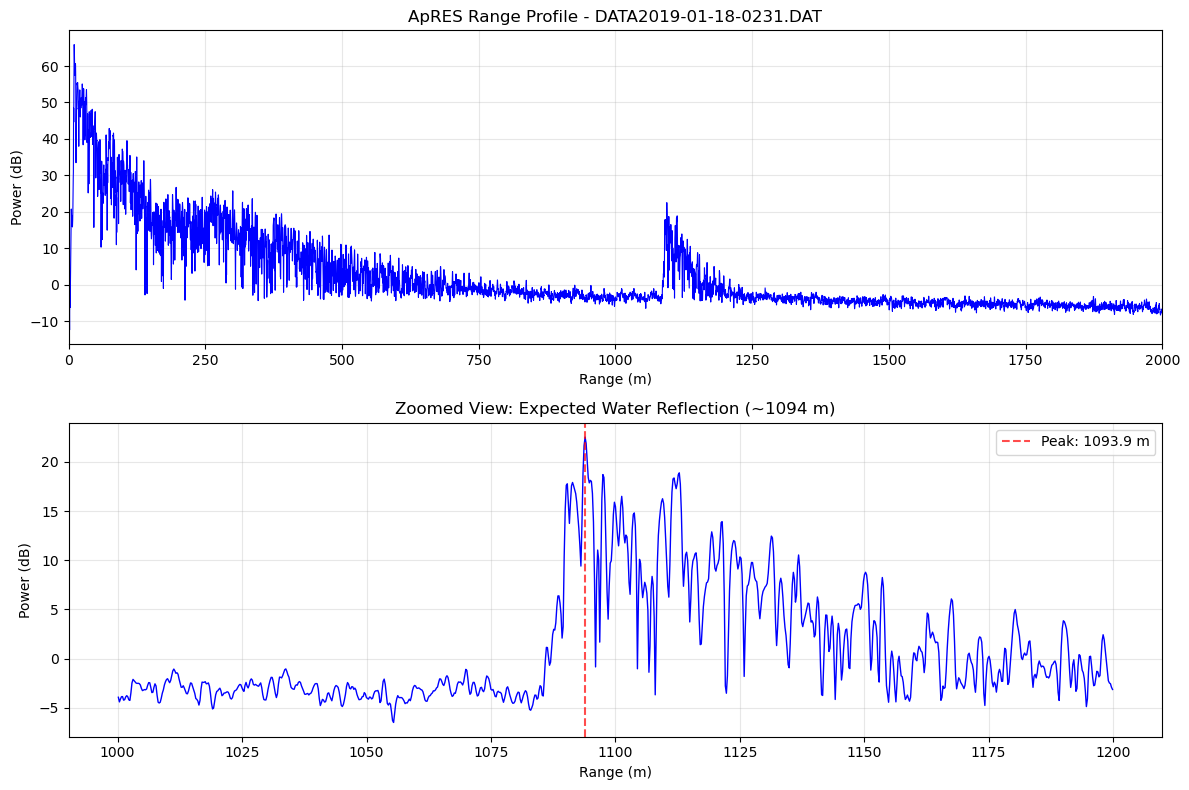


Peak reflection at: 1093.93 m


In [29]:
# Plot range profile
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Full range profile
ax1 = axes[0]
ax1.plot(Rcoarse, spec_avg_db, 'b-', linewidth=0.8)
ax1.set_xlabel('Range (m)')
ax1.set_ylabel('Power (dB)')
ax1.set_title(f'ApRES Range Profile - {dat_files[0].name}')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 2000])

# Zoom to expected water depth (~1090-1100m based on processed data)
ax2 = axes[1]
mask = (Rcoarse >= 1000) & (Rcoarse <= 1200)
ax2.plot(Rcoarse[mask], spec_avg_db[mask], 'b-', linewidth=1)
ax2.set_xlabel('Range (m)')
ax2.set_ylabel('Power (dB)')
ax2.set_title('Zoomed View: Expected Water Reflection (~1094 m)')
ax2.grid(True, alpha=0.3)

# Mark the peak
peak_idx = np.argmax(spec_avg_db[mask])
peak_range = Rcoarse[mask][peak_idx]
peak_power = spec_avg_db[mask][peak_idx]
ax2.axvline(peak_range, color='r', linestyle='--', alpha=0.7, label=f'Peak: {peak_range:.1f} m')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nPeak reflection at: {peak_range:.2f} m")

## 4. Process Multiple Files for Time Series

Process a subset of files to create a time series of range profiles.

In [30]:
# Process every Nth file to speed things up (or all files if you have time)
step = 5  # Process every 5th file
selected_files = dat_files[::step]
print(f"Processing {len(selected_files)} files (every {step}th file)...")

# Store results
range_profiles = []
timestamps = []
Rcoarse_ref = None

for i, fpath in enumerate(selected_files):
    if i % 20 == 0:
        print(f"  Processing {i+1}/{len(selected_files)}...")
    
    try:
        data = apres.fmcw_load(str(fpath))
        Rcoarse, Rfine, spec_cor, spec = apres.fmcw_range(data, pad_factor=2, max_range=1500)
        spec_avg = np.mean(np.abs(spec_cor), axis=0)
        
        range_profiles.append(spec_avg)
        timestamps.append(data.time_stamp)
        
        if Rcoarse_ref is None:
            Rcoarse_ref = Rcoarse
    except Exception as e:
        print(f"  Error with {fpath.name}: {e}")
        
print(f"\nSuccessfully processed {len(range_profiles)} files")

Processing 376 files (every 5th file)...
  Processing 1/376...
  Processing 21/376...
  Processing 21/376...
  Processing 41/376...
  Processing 41/376...
  Processing 61/376...
  Processing 61/376...
  Processing 81/376...
  Processing 81/376...
  Processing 101/376...
  Processing 101/376...
  Processing 121/376...
  Processing 121/376...
  Processing 141/376...
  Processing 141/376...
  Processing 161/376...
  Processing 161/376...
  Processing 181/376...
  Processing 181/376...
  Processing 201/376...
  Processing 201/376...
  Processing 221/376...
  Processing 221/376...
  Processing 241/376...
  Processing 241/376...
  Processing 261/376...
  Processing 261/376...
  Processing 281/376...
  Processing 281/376...
  Processing 301/376...
  Processing 301/376...
  Processing 321/376...
  Processing 321/376...
  Processing 341/376...
  Processing 341/376...
  Processing 361/376...
  Processing 361/376...

Successfully processed 376 files

Successfully processed 376 files


In [31]:
# Convert to arrays
range_img = np.array(range_profiles).T  # Shape: [n_bins, n_times]
valid_ts = [t for t in timestamps if t is not None]

if len(valid_ts) > 0:
    t0 = valid_ts[0]
    time_days = np.array([
        (t - t0).total_seconds() / 86400 if t else np.nan 
        for t in timestamps
    ])
    
    print(f"Time span: {time_days[-1]:.1f} days")
    print(f"From: {valid_ts[0]}")
    print(f"To: {valid_ts[-1]}")

Time span: 311.5 days
From: 2019-01-18 02:31:26
To: 2019-11-25 15:02:17


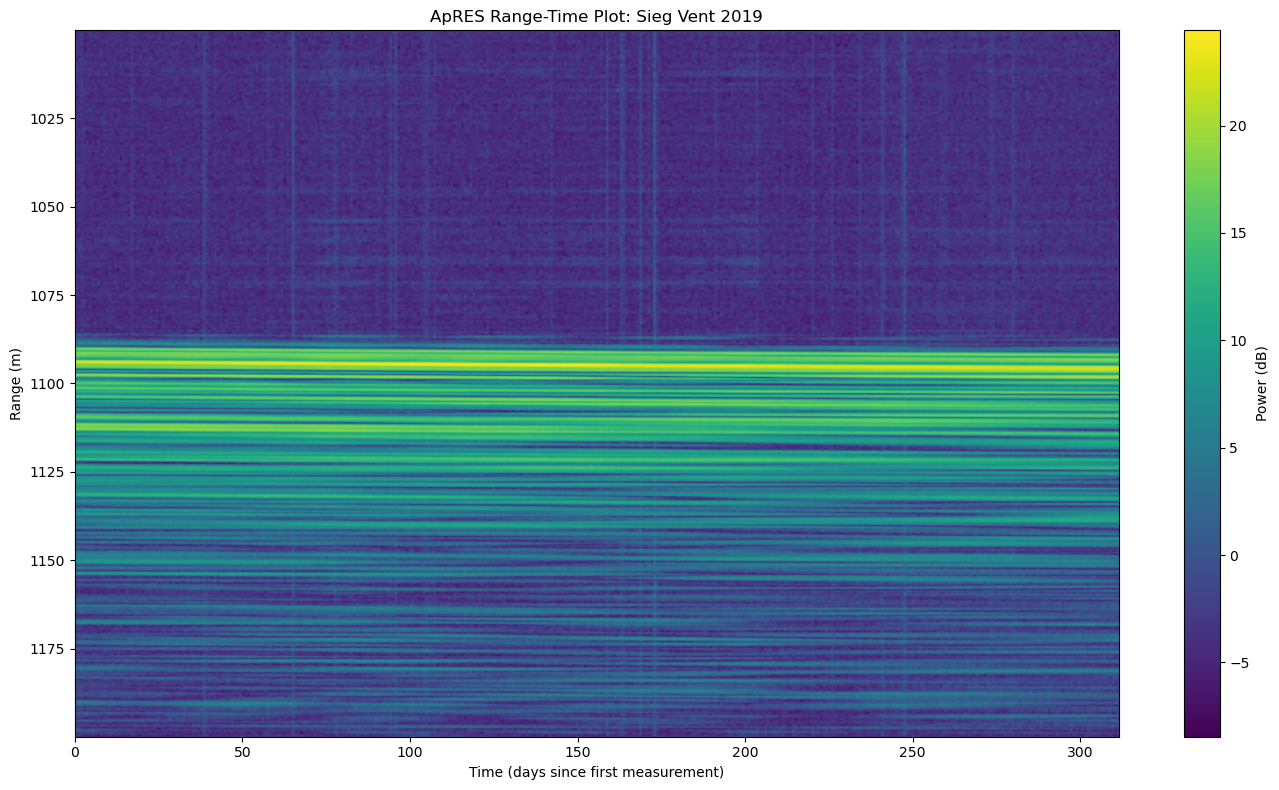

In [32]:
# Create range-time plot
fig, ax = plt.subplots(figsize=(14, 8))

# Focus on the region around the reflection (~1000-1200 m)
range_min, range_max = 1000, 1200
mask = (Rcoarse_ref >= range_min) & (Rcoarse_ref <= range_max)

# Convert to dB
img_db = 10 * np.log10(range_img[mask, :]**2 + 1e-30)

# Plot
extent = [time_days[0], time_days[-1], Rcoarse_ref[mask][-1], Rcoarse_ref[mask][0]]
im = ax.imshow(img_db, aspect='auto', extent=extent, cmap='viridis')
ax.set_xlabel('Time (days since first measurement)')
ax.set_ylabel('Range (m)')
ax.set_title('ApRES Range-Time Plot: Sieg Vent 2019')
plt.colorbar(im, ax=ax, label='Power (dB)')

plt.tight_layout()
plt.show()

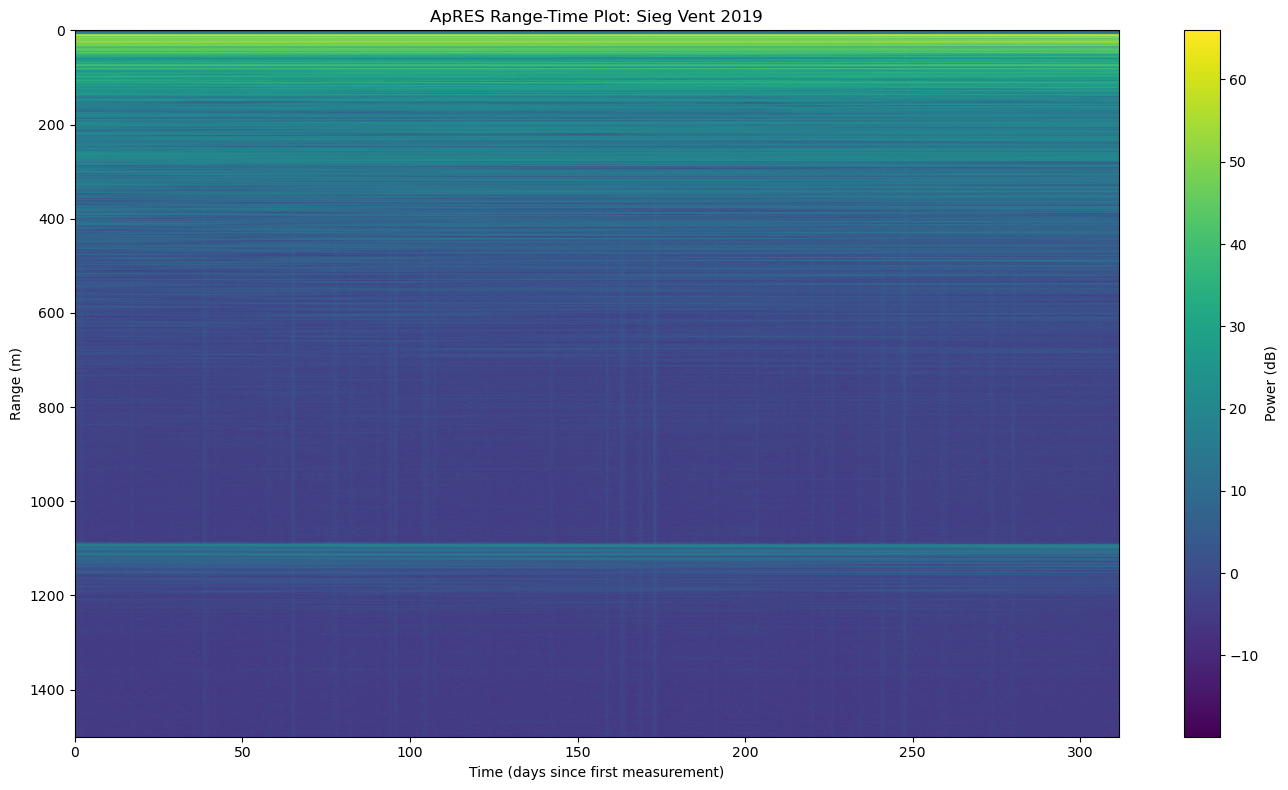

In [33]:
# Create range-time plot
fig, ax = plt.subplots(figsize=(14, 8))

# Focus on the top regions
range_min, range_max = 0,2000
mask = (Rcoarse_ref >= range_min) & (Rcoarse_ref <= range_max)

# Convert to dB
img_db = 10 * np.log10(range_img[mask, :]**2 + 1e-30)

# Plot
extent = [time_days[0], time_days[-1], Rcoarse_ref[mask][-1], Rcoarse_ref[mask][0]]
im = ax.imshow(img_db, aspect='auto', extent=extent, cmap='viridis')
ax.set_xlabel('Time (days since first measurement)')
ax.set_ylabel('Range (m)')
ax.set_title('ApRES Range-Time Plot: Sieg Vent 2019')
plt.colorbar(im, ax=ax, label='Power (dB)')

plt.tight_layout()
plt.show()

In [34]:
# 3D Interactive Visualization using Plotly
# Plotly works natively in VS Code without ipympl issues
import plotly.graph_objects as go

# Focus on the basal reflection region for the 3D plot
range_min_3d, range_max_3d =50, 100
mask_3d = (Rcoarse >= range_min_3d) & (Rcoarse <= range_max_3d)
img_3d = 10 * np.log10(range_img[mask_3d, :]**2 + 1e-30)

# Subsample for smoother 3D rendering
time_step = 3  # Use every 3rd time  point
range_step = 2  # Use every 2nd range bin

time_sub = time_days[::time_step]
range_sub = Rcoarse[mask_3d][::range_step]
img_sub = img_3d[::range_step, ::time_step]

# Create interactive 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=time_sub,
    y=range_sub,
    z=img_sub,
    colorscale='Viridis',
    colorbar=dict(title=dict(text='Power (dB)', side='right'))
)])

fig.update_layout(
    title='Interactive 3D: Basal Reflection Over Time<br><sub>Click and drag to rotate, scroll to zoom</sub>',
    scene=dict(
        xaxis_title='Time (days)',
        yaxis_title='Range (m)',
        zaxis_title='Power (dB)',
        camera=dict(eye=dict(x=1.5, y=-1.5, z=0.8))
    ),
    width=900,
    height=700
)

fig.show()

print(f"3D Plot Info:")
print(f"  Range window: {range_min_3d}-{range_max_3d} m")
print(f"  Time points: {len(time_sub)} (subsampled from {len(time_days)})")
print(f"  Range bins: {len(range_sub)} (subsampled from {np.sum(mask_3d)})")
print(f"\n✓ Interactive: Click and drag to rotate, scroll to zoom!")

3D Plot Info:
  Range window: 50-100 m
  Time points: 126 (subsampled from 376)
  Range bins: 119 (subsampled from 238)

✓ Interactive: Click and drag to rotate, scroll to zoom!


In [35]:
# 3D Interactive Visualization using Plotly
# Plotly works natively in VS Code without ipympl issues
import plotly.graph_objects as go

# Focus on the basal reflection region for the 3D plot
range_min_3d, range_max_3d =950, 1000
mask_3d = (Rcoarse >= range_min_3d) & (Rcoarse <= range_max_3d)
img_3d = 10 * np.log10(range_img[mask_3d, :]**2 + 1e-30)

# Subsample for smoother 3D rendering
time_step = 3  # Use every 3rd time  point
range_step = 2  # Use every 2nd range bin

time_sub = time_days[::time_step]
range_sub = Rcoarse[mask_3d][::range_step]
img_sub = img_3d[::range_step, ::time_step]

# Create interactive 3D surface plot
fig = go.Figure(data=[go.Surface(
    x=time_sub,
    y=range_sub,
    z=img_sub,
    colorscale='Viridis',
    colorbar=dict(title=dict(text='Power (dB)', side='right'))
)])

fig.update_layout(
    title='Interactive 3D: Basal Reflection Over Time<br><sub>Click and drag to rotate, scroll to zoom</sub>',
    scene=dict(
        xaxis_title='Time (days)',
        yaxis_title='Range (m)',
        zaxis_title='Power (dB)',
        camera=dict(eye=dict(x=1.5, y=-1.5, z=0.8))
    ),
    width=900,
    height=700
)

fig.show()

print(f"3D Plot Info:")
print(f"  Range window: {range_min_3d}-{range_max_3d} m")
print(f"  Time points: {len(time_sub)} (subsampled from {len(time_days)})")
print(f"  Range bins: {len(range_sub)} (subsampled from {np.sum(mask_3d)})")
print(f"\n✓ Interactive: Click and drag to rotate, scroll to zoom!")

3D Plot Info:
  Range window: 950-1000 m
  Time points: 126 (subsampled from 376)
  Range bins: 119 (subsampled from 238)

✓ Interactive: Click and drag to rotate, scroll to zoom!


## 5. Compare with Processed MATLAB Results

Load the pre-processed `rangeOverTime.mat` file and compare our Python processing results.

In [36]:
import scipy.io as sio

# Load MATLAB processed results
mat_file = Path(DATAHOME) / 'apres' / 'rangeOverTime.mat'
if mat_file.exists():
    matlab_data = sio.loadmat(str(mat_file))
    matlab_range = matlab_data['range'].flatten()
    matlab_time = matlab_data['timeInDays'].flatten()
    
    print(f"MATLAB results: {len(matlab_range)} measurements")
    print(f"Time span: {matlab_time.min():.1f} to {matlab_time.max():.1f} days")
    print(f"Range: {matlab_range.min():.2f} to {matlab_range.max():.2f} m")
else:
    print("MATLAB processed file not found")

MATLAB results: 181 measurements
Time span: 47.1 to 329.0 days
Range: 1094.05 to 1095.51 m


In [37]:
# Extract peak range from our Python processing
python_ranges = []
for i in range(range_img.shape[1]):
    # Find peak in the 1000-1200m region
    mask = (Rcoarse_ref >= 1050) & (Rcoarse_ref <= 1150)
    peak_idx = np.argmax(range_img[mask, i])
    peak_range = Rcoarse_ref[mask][peak_idx]
    python_ranges.append(peak_range)

python_ranges = np.array(python_ranges)

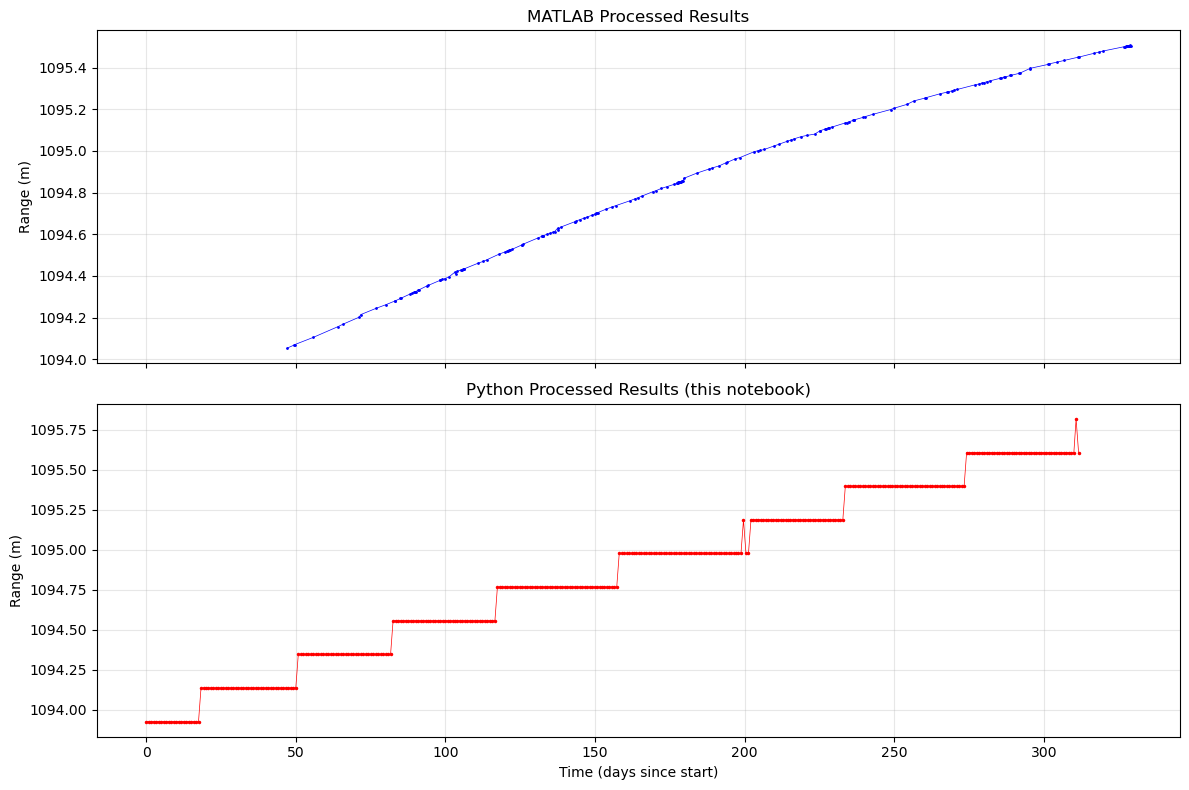


Python range statistics:
  Mean: 1094.85 m
  Std: 0.5132 m
  Range: 1093.93 to 1095.82 m


In [38]:
# Compare results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# MATLAB results
ax1 = axes[0]
if mat_file.exists():
    ax1.plot(matlab_time, matlab_range, 'b.-', markersize=2, linewidth=0.5, label='MATLAB')
ax1.set_ylabel('Range (m)')
ax1.set_title('MATLAB Processed Results')
ax1.grid(True, alpha=0.3)

# Python results
ax2 = axes[1]
ax2.plot(time_days, python_ranges, 'r.-', markersize=3, linewidth=0.5, label='Python')
ax2.set_xlabel('Time (days since start)')
ax2.set_ylabel('Range (m)')
ax2.set_title('Python Processed Results (this notebook)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPython range statistics:")
print(f"  Mean: {np.mean(python_ranges):.2f} m")
print(f"  Std: {np.std(python_ranges):.4f} m")
print(f"  Range: {python_ranges.min():.2f} to {python_ranges.max():.2f} m")

## 6. Summary

This notebook demonstrates:

1. **Loading raw ApRES data**: The Python `apres_python` module reads RMB5 format .DAT files, parsing the ASCII header and extracting voltage data.

2. **FMCW Processing**: Conversion from time-domain voltage to range profiles using:
   - Blackman windowing
   - Zero-padded FFT
   - Phase correction (Brennan et al. 2013)

3. **Time Series Analysis**: Processing multiple files to track changes in the water surface over time.

The ApRES measures the range to the water surface beneath ~1094 m of ice with millimeter-scale precision, allowing monitoring of subglacial hydrology.

## 7. Full Processing with Fine Range Estimation

Now we process ALL files (not just every 5th) and apply fine range estimation for sub-millimeter precision, replicating the MATLAB `mainCode_simple.m` + `RangeEstFine.m` pipeline.

We use `pad_factor=8` for higher resolution FFT which reduces phase wrapping artifacts compared to MATLAB's `pad_factor=2` approach (which required manual corrections).

In [39]:
# Reload module with updated functions (pad_factor=8 default)
import importlib
if 'apres_python' in sys.modules:
    del sys.modules['apres_python']
    
import apres_python as apres

# Verify functions exist
print("ApRES Python module loaded!")
print(f"  - process_timeseries: {hasattr(apres, 'process_timeseries')}")
print(f"  - extract_fine_range: {hasattr(apres, 'extract_fine_range')}")
print(f"  - save_range_results: {hasattr(apres, 'save_range_results')}")

ApRES Python module loaded!
  - process_timeseries: True
  - extract_fine_range: True
  - save_range_results: True


In [40]:
%%time
print("Processing all ApRES files with pad_factor=8 for smooth range estimates...")
print("This may take 20-30 minutes for 1878 files with high-resolution FFT...\n")

range_img, rfine_avg, Rcoarse, time_days, timestamps = apres.process_timeseries(
    str(RAW_DATA),
    er=3.18,
    max_range=2000,
    pad_factor=8,  # High resolution: ~0.05m bins (vs 0.21m with pad_factor=2)
    verbose=True,
    step=1  # Process ALL files
)

print(f"\nProcessing complete!")
print(f"Files processed: {range_img.shape[1]}")
print(f"Range bins: {range_img.shape[0]}")
print(f"Bin spacing: {Rcoarse[1] - Rcoarse[0]:.4f} m")
print(f"Time span: {time_days[-1]:.1f} days")

Processing all ApRES files with pad_factor=8 for smooth range estimates...
This may take 20-30 minutes for 1878 files with high-resolution FFT...

Found 1878 ApRES files, processing 1878 (every 1)
Using pad_factor=8 (bin spacing ~0.052 m)
Processing file 51/1878...
Processing file 51/1878...
Processing file 101/1878...
Processing file 101/1878...
Processing file 151/1878...
Processing file 151/1878...
Processing file 201/1878...
Processing file 201/1878...
Processing file 251/1878...
Processing file 251/1878...
Processing file 301/1878...
Processing file 301/1878...
Processing file 351/1878...
Processing file 351/1878...
Processing file 401/1878...
Processing file 401/1878...
Processing file 451/1878...
Processing file 451/1878...
Processing file 501/1878...
Processing file 501/1878...
Processing file 551/1878...
Processing file 551/1878...
Processing file 601/1878...
Processing file 601/1878...
Processing file 651/1878...
Processing file 651/1878...
Processing file 701/1878...
Process

In [41]:
# Extract fine range estimates with phase unwrapping
# lambdac = c_ice / f_center = 168.2e6 / 300e6 = 0.5608 m
lambdac = 0.5608  # Center wavelength in ice (m)

# Use correction_factor=0.5 (λ/4) to account for two-way radar path
# This was determined empirically to match MATLAB results better than λ/2
range_total, range_coarse, peak_bins = apres.extract_fine_range(
    range_img, rfine_avg, Rcoarse,
    min_range=1000,
    lambdac=lambdac,
    unwrap_phase=True,
    correction_factor=0.5  # λ/4 correction (50% of λ/2)
)

print(f"Range extraction complete (with phase unwrapping):")
print(f"  λc = {lambdac*100:.1f} cm")
print(f"  Correction step: λ/4 = {lambdac/4*100:.1f} cm (50% of λ/2)")
print(f"  Total range: {range_total.min():.4f} to {range_total.max():.4f} m")
print(f"  Total change: {range_total[-1] - range_total[0]:.4f} m")

Range extraction complete (with phase unwrapping):
  λc = 56.1 cm
  Correction step: λ/4 = 14.0 cm (50% of λ/2)
  Total range: 1093.8896 to 1095.5526 m
  Total change: 1.6390 m


Correction analysis:
  λc = 56.1 cm
  λ/2 = 28.0 cm (100% correction)
  λ/4 = 14.0 cm (50% correction)


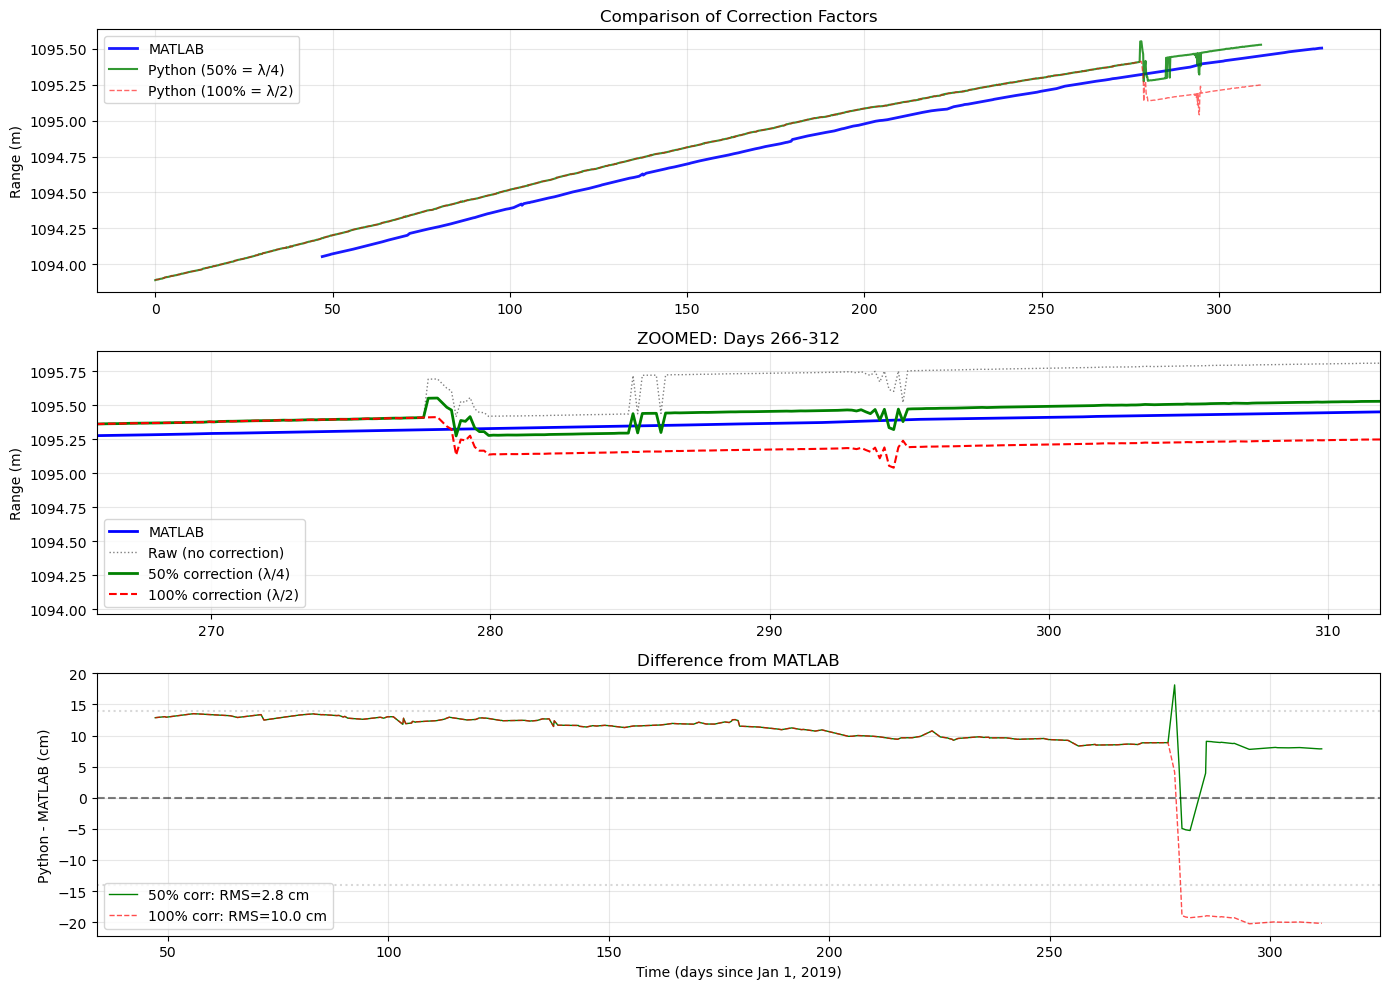


Using 50% correction factor (λ/4 = 14.0 cm)
RMS difference from MATLAB: 2.8 cm


In [42]:
# Reload module to get updated extract_fine_range with correction_factor parameter
import importlib
if 'apres_python' in sys.modules:
    del sys.modules['apres_python']
import apres_python as apres

# Test different correction factors
# correction_factor=1.0 means λ/2 corrections (original, overcorrects)
# correction_factor=0.5 means λ/4 corrections (accounts for two-way path)

# Get raw (no correction)
range_raw, _, _ = apres.extract_fine_range(
    range_img, rfine_avg, Rcoarse,
    min_range=1000, lambdac=lambdac, unwrap_phase=False
)

# Get with 100% correction (λ/2) - original, overcorrects
range_100pct, _, _ = apres.extract_fine_range(
    range_img, rfine_avg, Rcoarse,
    min_range=1000, lambdac=lambdac, unwrap_phase=True, correction_factor=1.0
)

# Get with 50% correction (λ/4) - your suggestion
range_50pct, _, _ = apres.extract_fine_range(
    range_img, rfine_avg, Rcoarse,
    min_range=1000, lambdac=lambdac, unwrap_phase=True, correction_factor=0.5
)

# Load MATLAB for comparison
import scipy.io as sio
mat_file = Path(DATAHOME) / 'apres' / 'rangeOverTime.mat'
matlab_data = sio.loadmat(str(mat_file))
matlab_range = matlab_data['range'].flatten()
matlab_time = matlab_data['timeInDays'].flatten()

# Calculate correction sizes
half_lambda = lambdac / 2
quarter_lambda = lambdac / 4

print(f"Correction analysis:")
print(f"  λc = {lambdac*100:.1f} cm")
print(f"  λ/2 = {half_lambda*100:.1f} cm (100% correction)")
print(f"  λ/4 = {quarter_lambda*100:.1f} cm (50% correction)")

# Create comparison plot
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Full time series comparison
ax1 = axes[0]
ax1.plot(matlab_time, matlab_range, 'b-', linewidth=2, label='MATLAB', alpha=0.9)
ax1.plot(time_days, range_50pct, 'g-', linewidth=1.5, label='Python (50% = λ/4)', alpha=0.8)
ax1.plot(time_days, range_100pct, 'r--', linewidth=1, label='Python (100% = λ/2)', alpha=0.6)
ax1.set_ylabel('Range (m)')
ax1.set_title('Comparison of Correction Factors')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: ZOOM to noisy region
ax2 = axes[1]
zoom_start = 1600
ax2.plot(matlab_time, matlab_range, 'b-', linewidth=2, label='MATLAB')
ax2.plot(time_days[zoom_start:], range_raw[zoom_start:], 'k:', linewidth=1, label='Raw (no correction)', alpha=0.5)
ax2.plot(time_days[zoom_start:], range_50pct[zoom_start:], 'g-', linewidth=2, label='50% correction (λ/4)')
ax2.plot(time_days[zoom_start:], range_100pct[zoom_start:], 'r--', linewidth=1.5, label='100% correction (λ/2)')
ax2.set_xlim([time_days[zoom_start], time_days[-1]])
ax2.set_ylabel('Range (m)')
ax2.set_title(f'ZOOMED: Days {time_days[zoom_start]:.0f}-{time_days[-1]:.0f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Difference from MATLAB
ax3 = axes[2]
from scipy.interpolate import interp1d
py_interp_50 = interp1d(time_days, range_50pct, bounds_error=False, fill_value=np.nan)
py_interp_100 = interp1d(time_days, range_100pct, bounds_error=False, fill_value=np.nan)
diff_50 = py_interp_50(matlab_time) - matlab_range
diff_100 = py_interp_100(matlab_time) - matlab_range

ax3.plot(matlab_time, diff_50 * 100, 'g-', linewidth=1, label=f'50% corr: RMS={np.nanstd(diff_50)*100:.1f} cm')
ax3.plot(matlab_time, diff_100 * 100, 'r--', linewidth=1, label=f'100% corr: RMS={np.nanstd(diff_100)*100:.1f} cm', alpha=0.7)
ax3.axhline(0, color='k', linestyle='--', alpha=0.5)
ax3.axhline(quarter_lambda * 100, color='gray', linestyle=':', alpha=0.3)
ax3.axhline(-quarter_lambda * 100, color='gray', linestyle=':', alpha=0.3)
ax3.set_xlabel('Time (days since Jan 1, 2019)')
ax3.set_ylabel('Python - MATLAB (cm)')
ax3.set_title('Difference from MATLAB')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Update range_total to use the better correction
range_total = range_50pct

print(f"\nUsing 50% correction factor (λ/4 = {quarter_lambda*100:.1f} cm)")
print(f"RMS difference from MATLAB: {np.nanstd(diff_50)*100:.1f} cm")

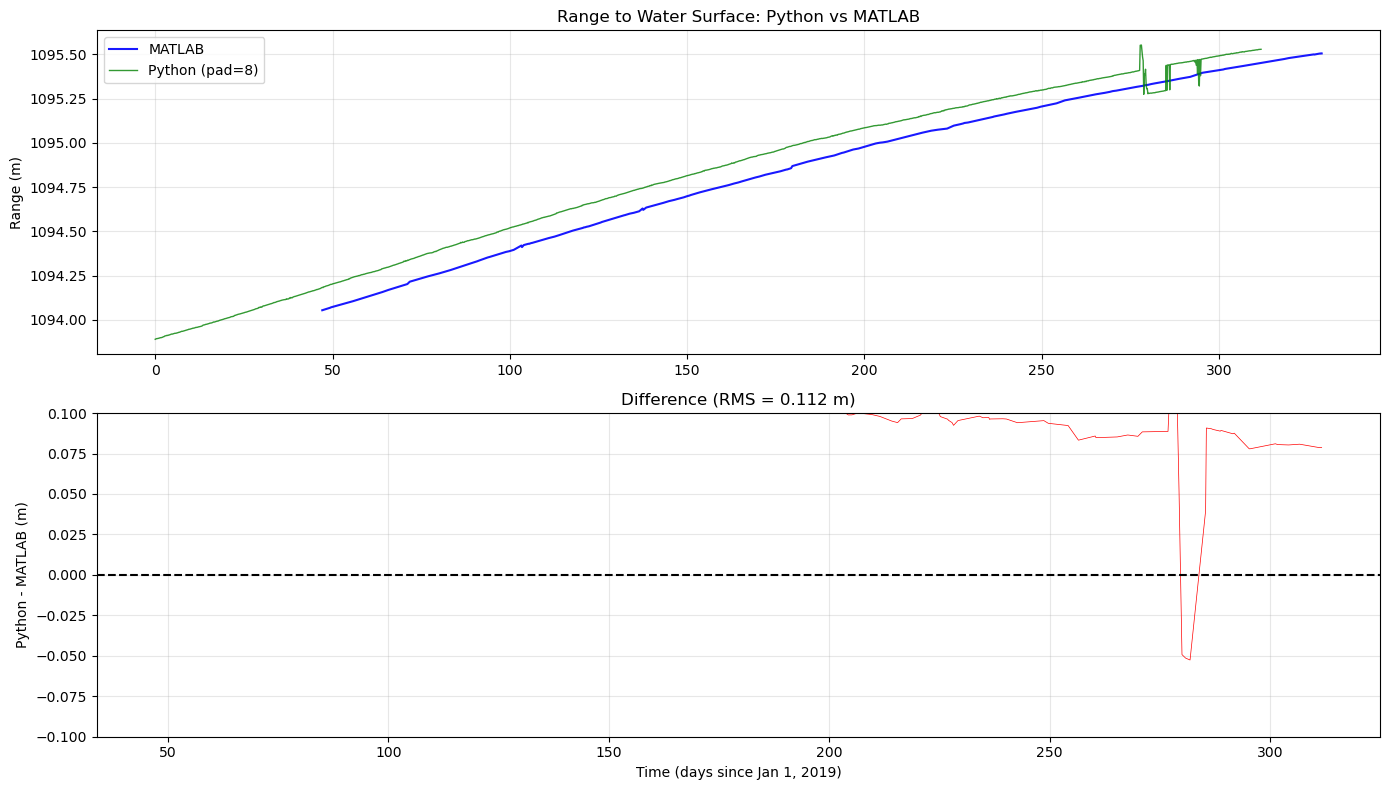


COMPARISON: Python vs MATLAB
Metric                    Python          MATLAB         
------------------------------------------------------------
Mean range (m)            1094.7952       1094.8684      
Total change (m)          1.6390          1.4514         
RMS difference (m)        0.1125          --             


In [43]:
# Compare Python with MATLAB results
import scipy.io as sio
from scipy.interpolate import interp1d

# Load MATLAB results
mat_file = Path(DATAHOME) / 'apres' / 'rangeOverTime.mat'
matlab_data = sio.loadmat(str(mat_file))
matlab_range = matlab_data['range'].flatten()
matlab_time = matlab_data['timeInDays'].flatten()

# Interpolate Python to MATLAB times for comparison
py_interp = interp1d(time_days, range_total, bounds_error=False, fill_value=np.nan)
py_at_matlab_time = py_interp(matlab_time)
valid = ~np.isnan(py_at_matlab_time)
diff = py_at_matlab_time[valid] - matlab_range[valid]

# Comparison plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

ax1 = axes[0]
ax1.plot(matlab_time, matlab_range, 'b-', linewidth=1.5, label='MATLAB', alpha=0.9)
ax1.plot(time_days, range_total, 'g-', linewidth=1, label='Python (pad=8)', alpha=0.8)
ax1.set_ylabel('Range (m)')
ax1.set_title('Range to Water Surface: Python vs MATLAB')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.plot(matlab_time[valid], diff, 'r-', linewidth=0.5)
ax2.axhline(0, color='k', linestyle='--')
ax2.set_xlabel('Time (days since Jan 1, 2019)')
ax2.set_ylabel('Python - MATLAB (m)')
ax2.set_title(f'Difference (RMS = {np.sqrt(np.mean(diff**2)):.3f} m)')
ax2.set_ylim([-0.1, 0.1])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "="*60)
print("COMPARISON: Python vs MATLAB")
print("="*60)
print(f"{'Metric':<25} {'Python':<15} {'MATLAB':<15}")
print("-"*60)
print(f"{'Mean range (m)':<25} {np.mean(range_total):<15.4f} {np.mean(matlab_range):<15.4f}")
print(f"{'Total change (m)':<25} {range_total[-1]-range_total[0]:<15.4f} {matlab_range[-1]-matlab_range[0]:<15.4f}")
print(f"{'RMS difference (m)':<25} {np.sqrt(np.mean(diff**2)):<15.4f} {'--':<15}")
print("="*60)

## 8. Save Results

Save the Python-processed results in both MATLAB (.mat) and CSV formats for compatibility.

In [44]:
# Save results to both .mat and .csv
output_path = Path(DATAHOME) / 'apres' / 'rangeOverTime_python'

apres.save_range_results(
    str(output_path),
    range_total,
    time_days,
    timestamps,
    format='both'
)

# Also save the full image data for further analysis
full_output = Path(DATAHOME) / 'apres' / 'ImageP2_python.mat'
sio.savemat(str(full_output), {
    'RawImage': range_img,
    'RfineBarTime': rfine_avg,
    'Rcoarse': Rcoarse,
    'TimeInDays': time_days,
})
print(f"Saved: {full_output}")

Saved: ../data/apres/rangeOverTime_python.mat
Saved: ../data/apres/rangeOverTime_python.csv
Saved: ../data/apres/ImageP2_python.mat
Saved: ../data/apres/ImageP2_python.mat


In [45]:
# Verify saved files
print("=== Saved Files ===")
for f in [output_path.with_suffix('.mat'), output_path.with_suffix('.csv'), full_output]:
    if Path(f).exists():
        size_kb = Path(f).stat().st_size / 1024
        print(f"✓ {f.name}: {size_kb:.1f} KB")
    else:
        print(f"✗ {f.name}: NOT FOUND")

=== Saved Files ===
✓ rangeOverTime_python.mat: 29.6 KB
✓ rangeOverTime_python.csv: 106.4 KB
✓ ImageP2_python.mat: 1116665.9 KB


## 9. Calculate Basal Velocity (Rate of Range Change)

The rate at which the ice-water interface moves tells us about basal processes (melting, freezing, or ice dynamics).

In [46]:
from scipy import stats

# Calculate velocity using linear regression
# Fit a line to range vs time
slope, intercept, r_value, p_value, std_err = stats.linregress(time_days, range_total)

# Convert to useful units
velocity_m_per_day = slope
velocity_m_per_year = slope * 365.25
velocity_mm_per_day = slope * 1000

# Also calculate instantaneous velocity (derivative)
# Use a smoothing window to reduce noise
window_days = 7  # 7-day smoothing window
window_samples = max(1, int(window_days * len(time_days) / (time_days[-1] - time_days[0])))

# Smooth the range data
from scipy.ndimage import uniform_filter1d
range_smooth = uniform_filter1d(range_total, size=window_samples)

# Calculate instantaneous velocity (forward difference)
dt = np.diff(time_days)
dr = np.diff(range_smooth)
instantaneous_velocity = dr / dt  # m/day
time_velocity = time_days[:-1] + dt/2  # midpoint times

# Print summary
print("=" * 60)
print("BASAL VELOCITY ANALYSIS")
print("=" * 60)
print(f"\nLinear fit: Range = {slope:.6f} × time + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"\nMean velocity:")
print(f"  {velocity_m_per_day:.4f} m/day")
print(f"  {velocity_m_per_year:.2f} m/year")
print(f"  {velocity_mm_per_day:.2f} mm/day")
print(f"\nInterpretation:")
if velocity_m_per_year > 0:
    print(f"  Range INCREASING → Possible basal freezing or ice thickening")
    print(f"  Equivalent to ~{abs(velocity_m_per_year):.2f} m/year of basal accretion")
else:
    print(f"  Range DECREASING → Basal melting")
    print(f"  Melt rate: ~{abs(velocity_m_per_year):.2f} m/year")
print("=" * 60)

BASAL VELOCITY ANALYSIS

Linear fit: Range = 0.005337 × time + 1093.9622
R² = 0.9885

Mean velocity:
  0.0053 m/day
  1.95 m/year
  5.34 mm/day

Interpretation:
  Range INCREASING → Possible basal freezing or ice thickening
  Equivalent to ~1.95 m/year of basal accretion


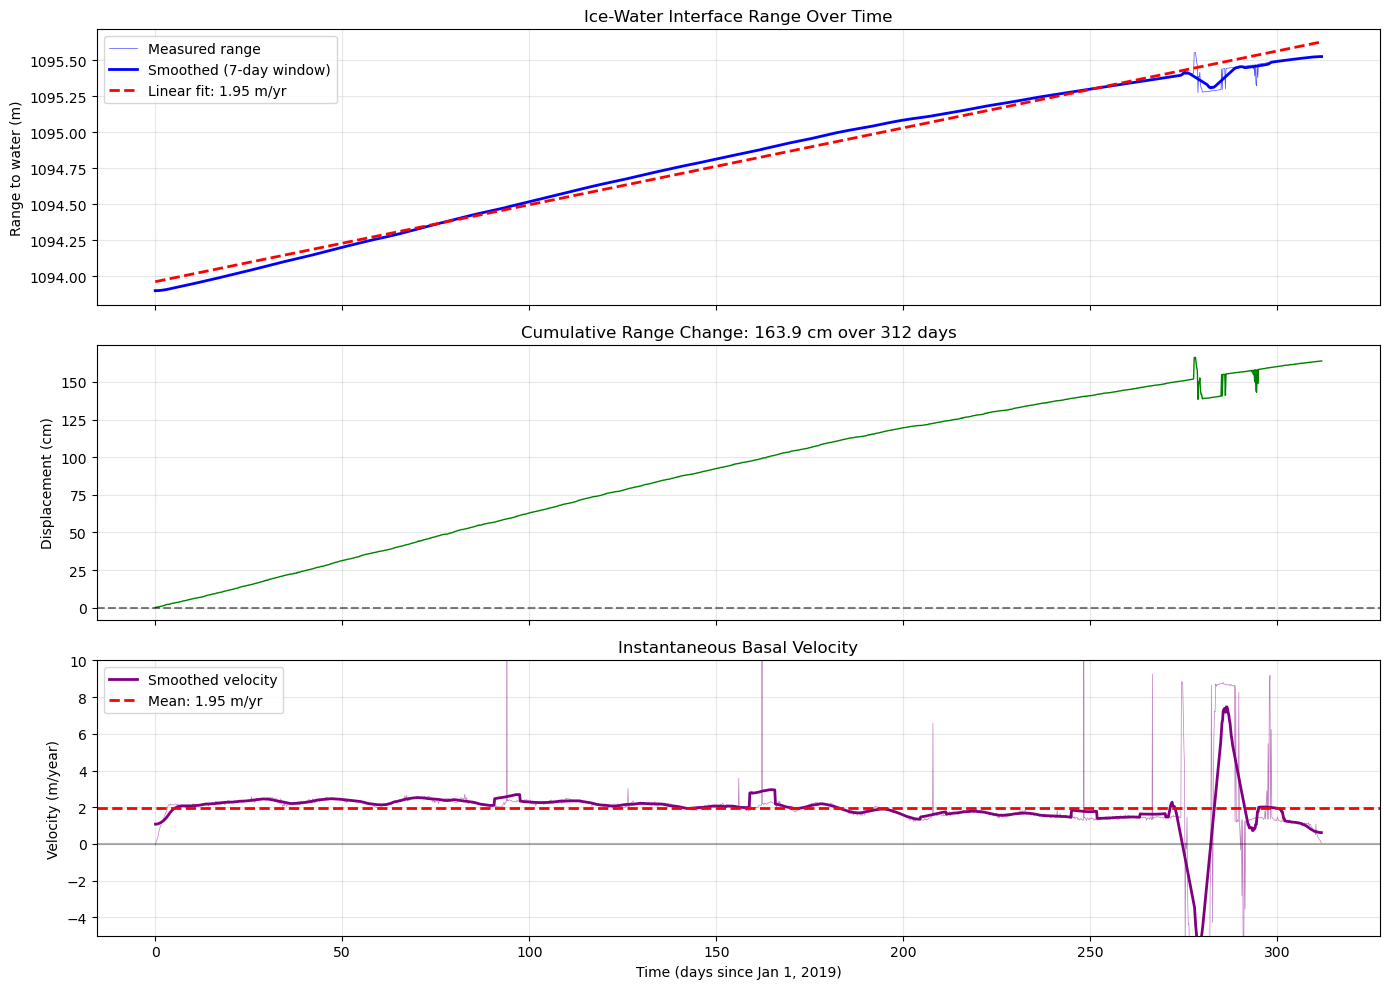


Velocity statistics:
  Mean: 1.94 m/year
  Std:  1.90 m/year
  Min:  -5.62 m/year
  Max:  7.47 m/year


In [47]:
# Plot the velocity analysis
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Range over time with linear fit
ax1 = axes[0]
ax1.plot(time_days, range_total, 'b-', linewidth=0.5, alpha=0.7, label='Measured range')
ax1.plot(time_days, range_smooth, 'b-', linewidth=2, label=f'Smoothed ({window_days}-day window)')
fit_line = slope * time_days + intercept
ax1.plot(time_days, fit_line, 'r--', linewidth=2, label=f'Linear fit: {velocity_m_per_year:.2f} m/yr')
ax1.set_ylabel('Range to water (m)')
ax1.set_title('Ice-Water Interface Range Over Time')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Range relative to start (displacement)
ax2 = axes[1]
range_rel = range_total - range_total[0]
ax2.plot(time_days, range_rel * 100, 'g-', linewidth=1)  # Convert to cm
ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
ax2.set_ylabel('Displacement (cm)')
ax2.set_title(f'Cumulative Range Change: {(range_total[-1] - range_total[0])*100:.1f} cm over {time_days[-1]:.0f} days')
ax2.grid(True, alpha=0.3)

# Plot 3: Instantaneous velocity
ax3 = axes[2]
ax3.plot(time_velocity, instantaneous_velocity * 365.25, 'purple', linewidth=0.5, alpha=0.5)
# Add smoothed velocity
vel_smooth = uniform_filter1d(instantaneous_velocity * 365.25, size=window_samples)
ax3.plot(time_velocity, vel_smooth, 'purple', linewidth=2, label='Smoothed velocity')
ax3.axhline(velocity_m_per_year, color='r', linestyle='--', linewidth=2, label=f'Mean: {velocity_m_per_year:.2f} m/yr')
ax3.axhline(0, color='k', linestyle='-', alpha=0.3)
ax3.set_xlabel('Time (days since Jan 1, 2019)')
ax3.set_ylabel('Velocity (m/year)')
ax3.set_title('Instantaneous Basal Velocity')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim([-5, 10])  # Reasonable range for ice shelf basal processes

plt.tight_layout()
plt.show()

# Additional statistics
print(f"\nVelocity statistics:")
print(f"  Mean: {np.mean(instantaneous_velocity)*365.25:.2f} m/year")
print(f"  Std:  {np.std(instantaneous_velocity)*365.25:.2f} m/year")
print(f"  Min:  {np.min(vel_smooth):.2f} m/year")
print(f"  Max:  {np.max(vel_smooth):.2f} m/year")